In [1]:
import os
import pandas as pd
import numpy as np
import numpy.linalg as la
from numpy.random import uniform, normal
import matplotlib.pyplot as plt
import cvxpy as cp
plt.rcParams.update({'font.size': 15})

# VAR Models
https://www.asc.ohio-state.edu/de-jong.8/note6.pdf

In [19]:
class VARMA:
    """
    d:= Number of Series
    p:= AR(p) model
    q:= MA(q) model
    N:= Length of Series
    """
    def __init__(self, d, p, q, N):
        self.d = d
        self.p = p
        self.q = q
        self.N = N
        self.PHI = None
        self.THETA = None
              
    def generate_coefs(self, c_range, k):
        """  
        c_range:= (float) coef range
        arma_type = (string) 'ar' or 'ma' not case sensitive
        k:= (int) either p or q value of d-dimensional VARMA(p,q)
        
        returns coefficient matrix of an arbitrary stationary process
        """ 
        d = self.d
        Matr = np.zeros(shape = (k*d, k*d))
        root_test = False
        while root_test != True:

            # creating k (dxd) coef matricies with random coefs
            coefs = np.array([uniform(-c_range, c_range, size = (d,d)) for i in range(k)])
            coefs[abs(coefs) < 0.1] = 0

            # creating pd-dimesnional Var(1) coef matrix 
            Matr[:d, :k*d] = np.concatenate(coefs, axis = 1)
            Matr[d:k*d, :-d] = np.identity((k-1)*(d))
            
            # testing if all roots z are s.t. |z| > 1
            eigen_vals = la.eig(Matr)[0]           
            root_test = all(list(map(lambda x: np.abs(x) < 1, eigen_vals)))
        
        # flipping sign of ar coefficients
  
        return Matr
        
    def simulate(self):
        d, p, q, N = self.d, self.p, self.q, self.N
        pq_max = max([p,q])
        coef_range = 2
        
        # generating VARMA coeffs and creating lambda functions
        if p > 0:
            PHI = self.generate_coefs(coef_range, p)[:d]
            self.PHI = PHI
            ar = lambda x: PHI@np.concatenate(x)
        else:
            ar = lambda x: np.zeros(shape = (d,1))
        if q > 0:
            THETA = self.generate_coefs(coef_range, q)[:d]
            self.THETA = THETA
            ma = lambda x: THETA@np.concatenate(x)
        else:
            ma = lambda x: np.zeros(shape = (d,1))
        
        # propogating VARMA model
        std_x, std_e = 1, 1
        x = [normal(0, std_x, size = (d,1)) for i in range(pq_max)]
        e = [normal(0, std_e, size = (d,1)) for i in range(pq_max)]
        for _ in range(N):
            error_t = normal(0, std_e, size = (d,1))
            X_t = ar(x[:-p-1:-1]) + ma(e[:-q-1:-1]) + error_t
            e.append(error_t)
            x.append(X_t)
              
        # storing series in dataframe
        x = np.array(x)[pq_max:]
        df = pd.DataFrame(x[:,:,0], columns = ['x{}'.format(i) for i in range(1,d+1)])
        return df

In [28]:
d = 3
p = 2
q = 2
N = 200

V = VARMA(d, p, q, N)
df = V.simulate()

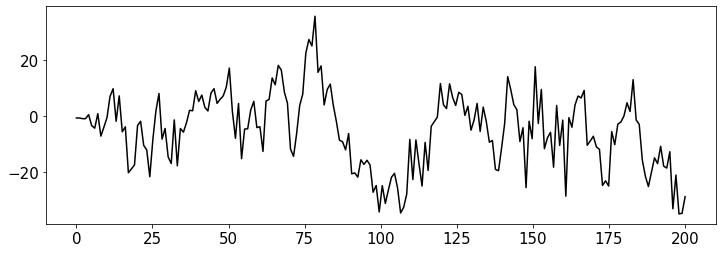

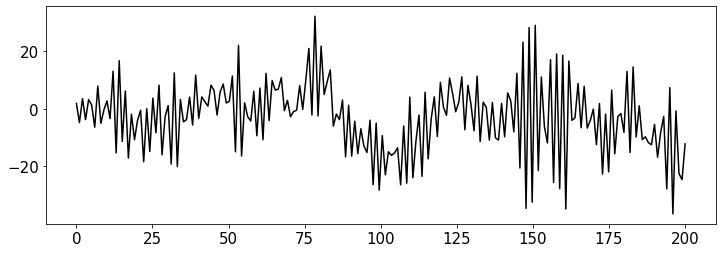

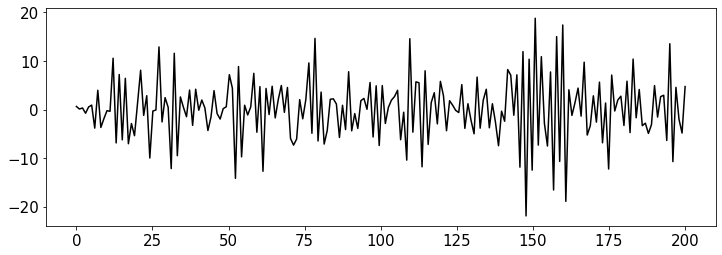

In [29]:
for col in df.columns:
    
    X_t = df[col].values
    fig, (ax0) = plt.subplots(1,1, figsize = (12,4))
    ax0.plot(np.linspace(0,N,N), X_t, color = 'k')
    plt.show()

# Spectral Methods

In [30]:
class spectral_ts:
    def __init__(self, raw_data, m):
        
        # data keys/attributes
        self.N, self.d = raw_data.shape
        
        # fourier frequencies and band init
        self.num_freqs = int(.5/(1/self.N))
        self.f_freqs = np.linspace(0, .5, self.num_freqs)
        self.L = 2*m+1 
        self.band = np.linspace(-m/self.N, m/self.N, self.L)
        
        # data structures
        self.mu_list = raw_data.mean()
        self.data = (raw_data-self.mu_list).to_numpy()
        self.sd_tensor = self.sd_estimates()
        
    def transform(self, func, w):
        return sum([self.data[t]*func(2*np.pi*w*t) for t in range(self.N)]).reshape(self.d, 1)
        
    def periodogram(self, w):
        # averaging over frequency band with size L = 2*m+1
        I = np.zeros(shape = (self.d, self.d))
        for m_n in self.band:
            d_cos, d_sin = self.transform(np.cos, w+m_n), self.transform(np.sin, w+m_n)
            I += d_cos@d_cos.T + d_sin@d_sin.T
        return I/(self.L*self.N)
    
    def sd_estimates(self):
        # creates tensor of dxd estimates of spectral density at freq w
        return np.array([self.periodogram(w) for w in self.f_freqs])
    
    def plot_pair(self, i, j):
        # overlays two time series and plots auto-cov and cross-spectrum 
        x = [i for i in range(len(self.data))]
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14,3))
        ax0.plot(x, self.data[:,i], color = 'k')
        ax0.plot(x, self.data[:,j], color = 'r')
        ax0.set_title('Observed Data')
        ax0.set_xlabel('t')
        ax1.plot(self.f_freqs, abs(self.sd_tensor[:,i,j]), color = 'k')
        ax1.set_title('Spectral Density Estimate')
        ax1.set_xlabel('freq')
        plt.show()

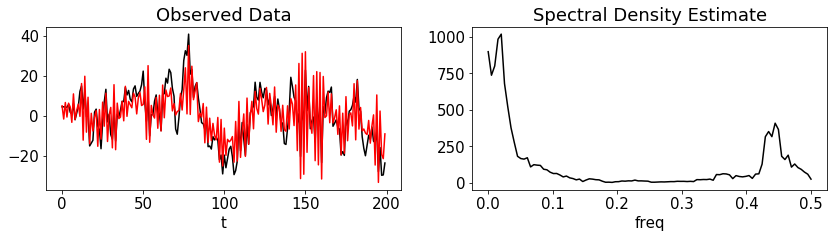

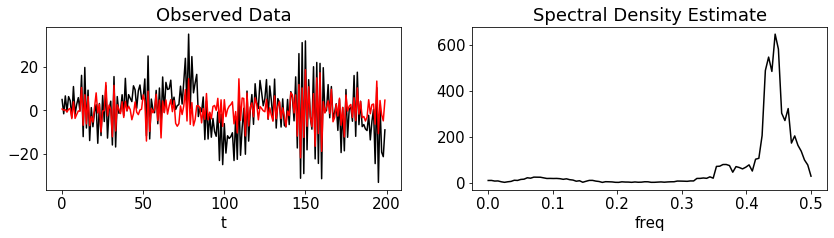

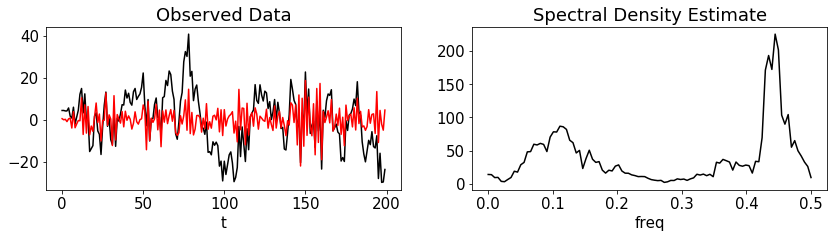

In [31]:
spec = spectral_ts(df, 2)
spec.plot_pair(0,1)
spec.plot_pair(1,2)
spec.plot_pair(0,2)

In [41]:
class S2FL(spectral_ts):
  
    def __init__(self, df, m):
        super().__init__(df, m)
        self.D = self.difference_matrix()
        
    def difference_matrix(self):
        return (np.identity(self.num_freqs) + np.diag([-1]*(self.num_freqs-1), k=1))[:-1]
    
    def l1_penalty(self, beta):
        return sum([cp.norm1(beta[t]) for t in range(self.num_freqs)])
    
    def mse(self, X, y, beta):
        return sum([(y[t] - sum([beta[t][i]*X[t][i] for i in range(self.d-1)]))**2 for t in range(self.num_freqs)])
    
    def fusion(self,beta):
        return sum(cp.norm1((self.D@beta).flatten()))
    
    def obj_function(self, X, y, beta, P0, P1):
        return self.mse(X,y,beta) + P0*self.l1_penalty(beta) + P1*self.fusion(beta)
    
    def stitch(self):
        pass
    
    def estimate_spectral_precision(self):
        
        estimates = []
        ts_index = list(range(self.d))
        sd_data = self.sd_tensor[:,ts_index,ts_index] 
        sd_data-=sd_data.mean()
        
        for i in ts_index:
            
            y = sd_data[:,i]
            X = sd_data[:,[j for j in ts_index if j!=i]]
            
            # Initializing hyperparamaters and regression coefficients.
            P0, P1 = cp.Parameter(nonneg=True), cp.Parameter(nonneg=True)
            beta = cp.Variable(shape = (self.num_freqs, self.d-1))
            OP = cp.Problem(cp.Minimize(self.obj_function(X, y, beta, P0, P1)))

            # Solving convex optimzation problem
            grid = np.linspace(0,10,4)
            param_pairs = [(i,j) for i in grid for j in grid]
            for p in param_pairs:
                P0.value, P1.value = p
                OP.solve(solver='ECOS')
                estimates.append({'ts_index': i,
                                  'hyper_params': p,
                                  'error': OP.value, 
                                  'beta_matrix': beta.value})
        return pd.DataFrame(estimates)

In [42]:
test = S2FL(df,2)

estimates = test.estimate_spectral_precision().sort_values(by = ['error'])

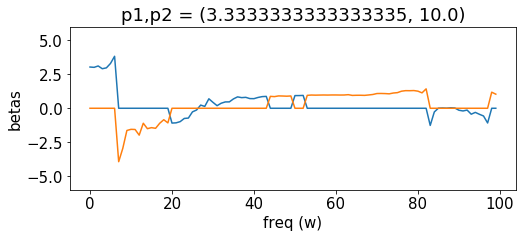

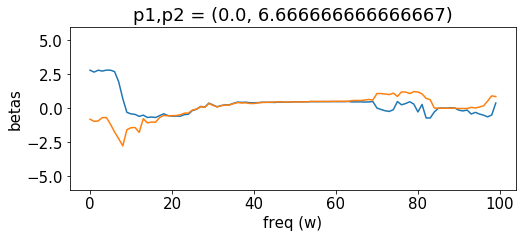

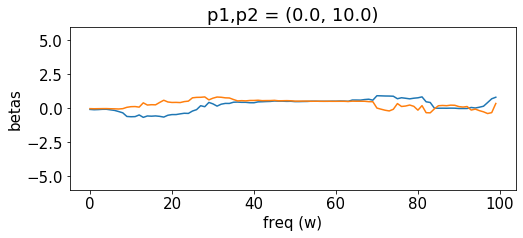

In [51]:
plot_N = [np.random.randint(0,len(estimates)) for i in range(3)]
for i in plot_N:
    plt.figure(figsize = (8,3))
    row = estimates.iloc[i]
    beta_mat = row['beta_matrix'].T
    for i in beta_mat:
        plt.plot([i for i in range(G.num_freqs)], i)
        plt.title('p1,p2 = {}'.format(row['hyper_params']))
        plt.xlabel('freq (w)')
        plt.ylabel('betas')
        plt.ylim([-6,6])
        plt.show()